In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from tensorflow import keras
import geopandas as gpd
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random
import rasterio
import numpy as np
import glob
from rasterio.plot import reshape_as_image
from tensorflow.keras import models

from LimeImageExplainer2 import LimeImageExplainer2


In [2]:
import visualkeras
from PIL import ImageFont

# Without the Mask Layer

In [ ]:
# Iowa_2021_july_1280-3072 ## Test patch (Normal)


In [3]:

file_name = "Iowa_2021_july_3584-4096" ## Deviating true val vs predict
img_path = 'Input/sentinel/patches_256/Iowa_July_1_31/test/'+file_name+'.tif'
file = rasterio.open(img_path)
img = reshape_as_image(file.read())
# file.close()
img_batch1 = np.expand_dims(img, axis=0)

img_batch = img_batch1[:,:,:,0:12]
# model_id = "aanaxs4g" # With mask
model_id = "ezb3xkqf" # No Mask
model_path = glob.glob("wandb/"+ "*"+model_id+"*" + "/files/model-best.h5")[0]
ev_gdf = gpd.read_file("Output/Evaluation/"+model_id+".shp")
# print(model_path)
cnn_model = models.load_model(model_path)

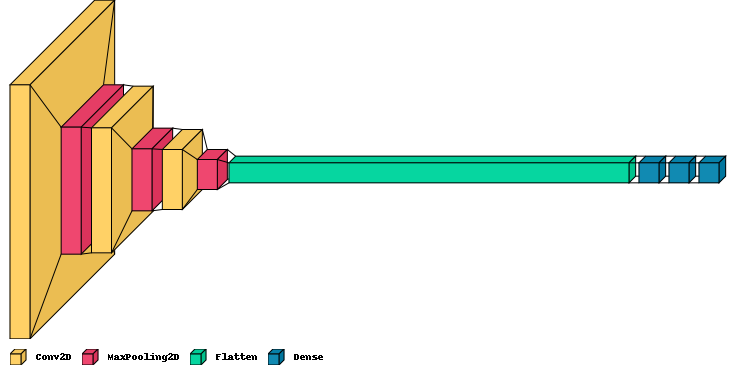

In [4]:
visualkeras.layered_view(cnn_model, to_file="cnn_model_architecture.png",legend=True,scale_z=0.020,scale_xy=1)

In [5]:
ev_gdf.query("patch_name == 'Iowa_2021_july_1280-3072'")

,patch_name,true_val,ezb3xkqf,geometry
412,Iowa_2021_july_1280-3072,1.595113,2.514298,"POLYGON ((-95.81179 41.70752, -95.94977 41.707..."


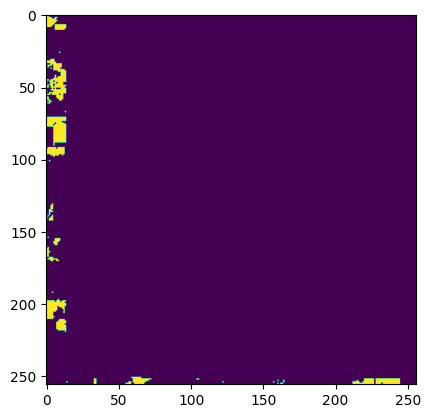

In [6]:
plt.imshow(img_batch1[0][:,:,12])

In [7]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [25]:
# model_builder = keras.applications.xception.Xception
# img_size = (299, 299)
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

# last_conv_layer_name = "block14_sepconv2_act"

# # The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
# )

# display(Image(img_path))

In [8]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print(grads.shape)
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    print(heatmap.shape)
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [9]:
cnn_model.layers[-1].activation = None
pred = cnn_model.predict(img_batch)
print(f"Prediction : {pred}")

1/1 [==============================] - 0s 149ms/step
Prediction : [[1.9704759]]


(1, 60, 60, 64)
(60, 60, 1)


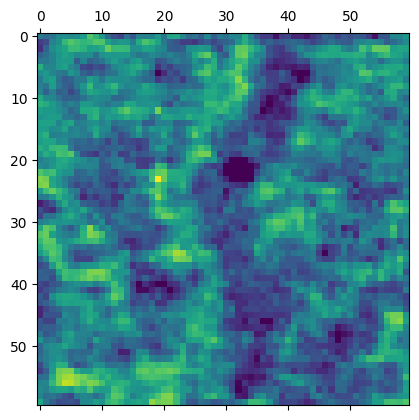

In [10]:
# Generate class activation heatmap
last_conv_layer_name = "conv2d_2"
heatmap = make_gradcam_heatmap(img_batch, cnn_model, last_conv_layer_name)
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [12]:
heatmap.shape

(60, 60)

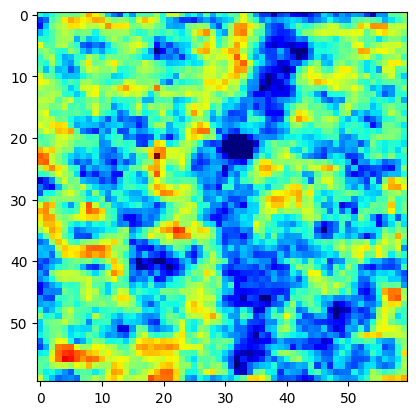

In [18]:
# save_and_display_gradcam(img_path, heatmap)
# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
plt.imshow(jet_heatmap)

In [20]:
jet_heatmap.shape

(60, 60, 3)

In [26]:
# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((256,256))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

In [27]:
jet_heatmap.shape

(256, 256, 3)

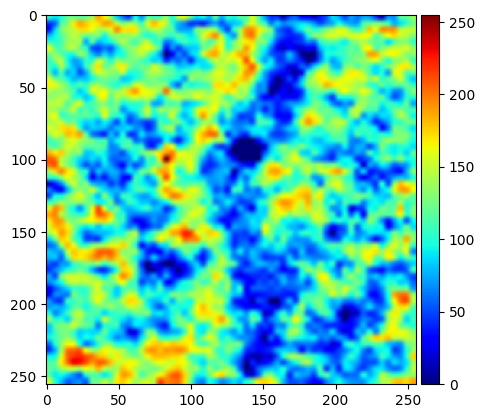

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(jet_heatmap.astype(np.uint8),cmap="jet")
plt.colorbar(im, cax=cax)

In [ ]:
with open('Output/saliency_maps/gradCAM/Iowa_2021_july_1280-3072_'+str(model_id)+'.npy', 'wb') as f:
    np.save(f, jet_heatmap)

In [15]:
heatmap.shape

(60, 60)

# With the mask Layer

In [29]:
img_batch1 = np.expand_dims(img, axis=0)
img_batch = img_batch1
model_id = "aanaxs4g" # With mask
# model_id = "ezb3xkqf" # No Mask
model_path = glob.glob("wandb/"+ "*"+model_id+"*" + "/files/model-best.h5")[0]
ev_gdf = gpd.read_file("Output/Evaluation/"+model_id+".shp")
# print(model_path)
cnn_model = models.load_model(model_path)

In [31]:
ev_gdf.query("patch_name =='"+str(file_name)+"'")

,patch_name,true_val,aanaxs4g,geometry
363,Iowa_2021_july_3584-4096,0.164877,0.188881,"POLYGON ((-94.56996 41.15560, -94.70794 41.155..."


In [32]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      3776      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [33]:
cnn_model.layers[-1].activation = None
pred = cnn_model.predict(img_batch)
print(f"Prediction : {pred}")

1/1 [==============================] - 0s 61ms/step
Prediction : [[0.18888055]]


(1, 60, 60, 64)
(60, 60, 1)


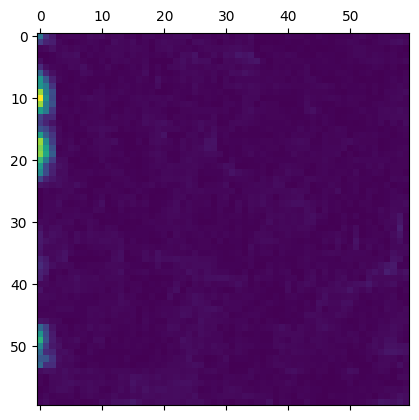

In [34]:
# Generate class activation heatmap
last_conv_layer_name = "conv2d_2"
heatmap = make_gradcam_heatmap(img_batch, cnn_model, last_conv_layer_name)
# Display heatmap
plt.matshow(heatmap)
plt.show()

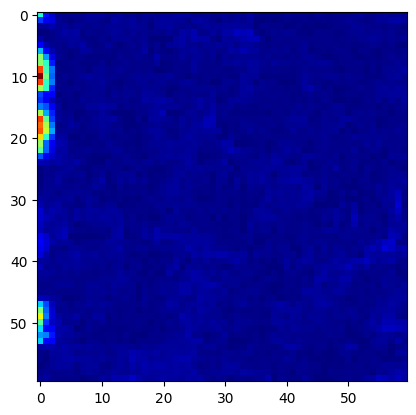

In [35]:
# save_and_display_gradcam(img_path, heatmap)
# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
plt.imshow(jet_heatmap)

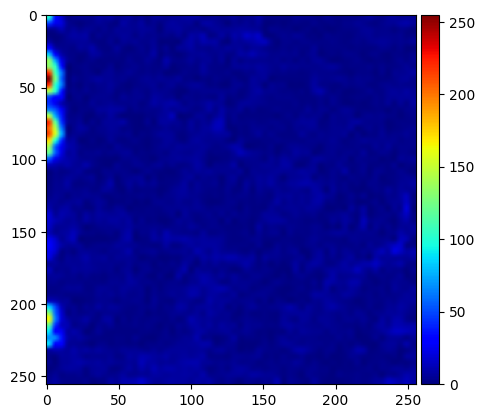

In [36]:
# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((256,256))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(jet_heatmap.astype(np.uint8),cmap="jet")
plt.colorbar(im, cax=cax)

In [31]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))